In [1]:
from typing import List, Tuple
import copy
import numpy as np

from src.environment import *
from src.agents import *
from src.visualization import *

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# #interface to try manually move agents
# env = CliffBoxGridWorld(render=True)
# env.reset()
# env.print_world()
# done = False
# rewards = []

# while not done:
#     action = int(input("Please input the actions (up: 1, down: 2, left: 3, right: 4): "))
#     state, reward, done, info = env.step(action)
#     rewards.append(reward)
#     print(f'step: {env.timesteps}, state: {state}, actions: {action}, reward: {reward}')
#     env.print_world()

# print(f'rewards: {sum(rewards)}')
# print(f'action history: {env.action_history}')

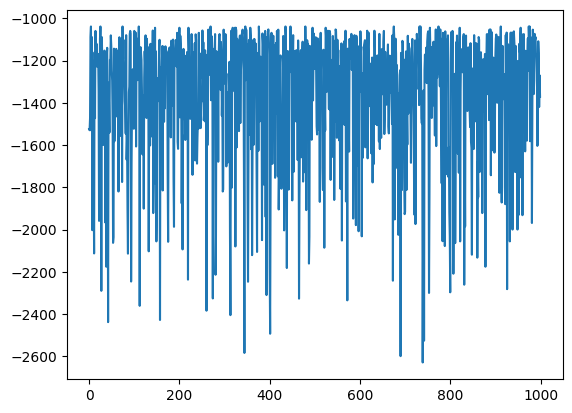

In [3]:
#example of training a random agent
env = CliffBoxGridWorld()
agent = RandomAgent(env, num_episodes=1000)
rewards = agent.learn()

# Plot the learning curve
plt.plot(rewards)

Success rate: 0.0


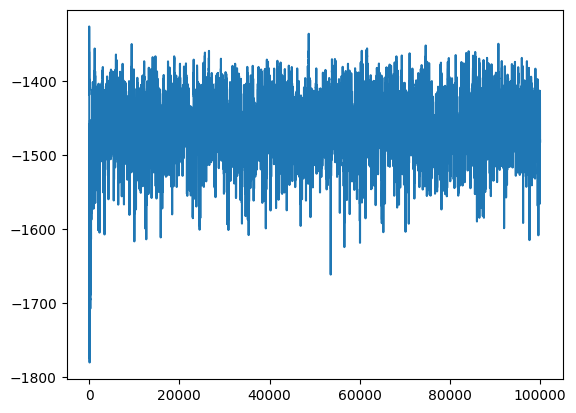

In [ ]:
#train custom model
env = CliffBoxGridWorld()
agent = RLAgent(env, num_episodes=15000)
# agent = RLAgent(env, num_episodes=100000)
rewards = agent.learn()

# Calculate success rate
final_rewards = np.array(rewards[-2000:])
success_rate = np.sum(final_rewards > 0) / len(final_rewards)
print(f"Success rate: {success_rate}")

# Smooth plot
weight=0.95
last = rewards[0]
smoothed = []
for v in rewards:
    smoothed_val = last * weight + (1 - weight) * v
    smoothed.append(smoothed_val)
    last = smoothed_val

# Plot the learning curve
plt.plot(smoothed)

In [5]:
#visualize training results
visualize(agent.q_table)

State space: 7056
v_table (0, 0, 0, 0) 0.0
policy (0, 0, 0, 0) 1
v_table (0, 0, 0, 1) 0.0
policy (0, 0, 0, 1) 1
v_table (0, 0, 0, 2) 0.0
policy (0, 0, 0, 2) 1
v_table (0, 0, 0, 3) 0.0
policy (0, 0, 0, 3) 1
v_table (0, 0, 0, 4) 0.0
policy (0, 0, 0, 4) 1
v_table (0, 0, 0, 5) 0.0
policy (0, 0, 0, 5) 1
v_table (0, 0, 0, 6) 0.0
policy (0, 0, 0, 6) 1
v_table (0, 0, 0, 7) 0.0
policy (0, 0, 0, 7) 1
v_table (0, 0, 0, 8) 0.0
policy (0, 0, 0, 8) 1
v_table (0, 0, 0, 9) 0.0
policy (0, 0, 0, 9) 1
v_table (0, 0, 0, 10) 0.0
policy (0, 0, 0, 10) 1
v_table (0, 0, 0, 11) 0.0
policy (0, 0, 0, 11) 1
v_table (0, 0, 0, 12) 0.0
policy (0, 0, 0, 12) 1
v_table (0, 0, 0, 13) 0.0
policy (0, 0, 0, 13) 1
v_table (0, 0, 1, 0) 0.0
policy (0, 0, 1, 0) 1
v_table (0, 0, 1, 5) 0.0
policy (0, 0, 1, 5) 1
v_table (0, 0, 1, 6) 0.0
policy (0, 0, 1, 6) 1
v_table (0, 0, 1, 7) 0.0
policy (0, 0, 1, 7) 1
v_table (0, 0, 1, 8) 0.0
policy (0, 0, 1, 8) 1
v_table (0, 0, 1, 9) 0.0
policy (0, 0, 1, 9) 1


In [6]:
#evaluate agent without exploration
env = CliffBoxGridWorld(render=True)
total_run = 1000
success = 0

for i in range(total_run):
    state = env.reset()
    done = False
    rewards = []
    
    while not done: 
        action = agent.act(state, is_training=False)
        next_state, reward, done, info = env.step(action)
        state = next_state
        rewards.append(reward)
    if sum(rewards) > 0:
        success += 1
print(success/total_run)

0.0


In [7]:
#evaluate agent with exploration and visualization
env = CliffBoxGridWorld(render=True)
state = env.reset()
env.print_world()
done = False
rewards = []

while not done: # Run until game terminated
    action = agent.act(state)
    next_state, reward, done, info = env.step(action)
    state = next_state
    rewards.append(reward)
    print(f'step: {env.timesteps}, state: {state}, actions: {action}, reward: {reward}')
    env.print_world()

print(f'rewards: {sum(rewards)}')
print(f'action history: {env.action_history}')

[[b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'x' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'_' b'_' b'_' b'_' b'x' b'x' b'_']
 [b'_' b'B' b'_' b'x' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'G']
 [b'A' b'_' b'_' b'x' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_']]
step: 1, state: (5, 1, 4, 1), actions: 4, reward: -14
Action: 4
[[b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'_' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'x' b'_' b'_' b'_' b'_' b'x' b'_']
 [b'_' b'_' b'_' b'x' b'_' b'_' b'x' b'_' b'_' b'_' b'_' b'x' b'x' b'_']
 [b'_' b'B' b'_' b'x' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'G']
 [b'_' b'A' b'_' b'x' b'_' b'_' b'_' b'_' b'_' b'_' b'_' b'x' b'x' b'_']]
step: 2, state: (5, 1, 4, 1), actions: 2, reward: -14
Acti